In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
#import seaborn as sns



Generamos 3 matrices de 7x9 que representen cada piso de la WitchHut e inicializamos el mob count en 0

In [3]:
def initialize_layers():
    return [[[False] * 9 for _ in range(7)] for _ in range(3)]

def initialize_mobs_per_layer():
    return [0, 0, 0]

La forma óptima es hacer el techo más alto de la granja a la altura 72, ese será nuestro heightMap.

El mobcap es, como siempre, 70.

Inicializamos la matriz y el mob count.

In [4]:
heightMap = 72
max_mobcap = 70
layers = initialize_layers()
mobs_per_layer = initialize_mobs_per_layer()

Para tener un promedio relativamente aceptable, veremos simulando 100 horas por caso.

In [5]:
testPeriodHours = 100
testPeriodSeconds = testPeriodHours * 3600
testPeriodTicks = testPeriodSeconds * 20

Simulamos la generación de las brujas sin tener en cuenta el movimiento, ya que sería computacionalmente caro y realmente no necesitamos tener muy en cuenta el pathfinding, la diferencia será mínima en general.

In [6]:
def generate_mobs(layers, heightMap):
    global mobs_per_layer
    if sum(mobs_per_layer) >= max_mobcap:
        return
    
    for _ in range(3):
        layer_index = random.randint(0, len(layers) - 1)
        layer = layers[layer_index]
        i = random.randint(0, len(layer) - 1)
        j = random.randint(0, len(layer[i]) - 1)

        if random.randint(1, heightMap) == 1:
            if layer[i][j] == False:
                layer[i][j] = True

                mobs_per_layer[layer_index] += 1

                for _ in range(random.randint(0, 3)):
                    offset_i = i + random.randint(-5, 5)
                    offset_j = j + random.randint(-5, 5)
                    if 0 <= offset_i < len(layer) and 0 <= offset_j < len(layer[i]):
                        layer[offset_i][offset_j] = True
                        mobs_per_layer[layer_index] += 1

No tendremos en cuenta el despawn ya que el jugador estará posicionado exactamente a 24 bloques de la capa inferior y a 32 bloques de la capa superior, permitiendo el spawn y evitando el despawn de las brujas.

La elección de sumar 74 cada vez que se ejecuta una acción del clock no es arbitraria, es exactamente lo que le toma al pulso de redstone activarse, luego lo que tarda en exapandirse el agua, luego desactivarse la redstone y luego desexpandirse el agua.

In [13]:
def test_farm(clock, delay_ticks):
    global mobs_per_layer
    global layers
    res = 0
    tick = 0
    while tick < testPeriodTicks:
        if clock == 0:
            tick = tick + 1
            continue
        if tick % clock == 0:
            res += sum(mobs_per_layer)
            tick = tick + 74 + delay_ticks
            mobs_per_layer = initialize_mobs_per_layer()
            layers = initialize_layers()

        generate_mobs(layers, heightMap)

        tick = tick + 1

    return res/testPeriodHours

Definimos los valores a probar del clock para descartar malas opciones y la función para ello

In [7]:
def test_clocks(clocks,delay_ticks):
    results = []
    max_res = 0
    max_clock = 0
    for clock in clocks:
        res = test_farm(clock,delay_ticks)
        if res >= max_res:
            max_res = res
            max_clock = clock
        results.append(res)
    return results, max_res, max_clock

def plot_clocks(clocks,results,delay):
    plt.plot(clocks, results)
    plt.xlabel('Clock')
    plt.ylabel('Avg. Witches per Hour')
    plt.title(f'Test Clocks Results for {delay} Ticks of Delay')
    plt.grid(True)
    plt.show()

def test_results(clocks,delay):
    results, max_res, max_clock = test_clocks(clocks, delay)
    plot_clocks(clocks,results, delay)
    print(f'Max: {max_res} for {max_clock} tick clock')
    return results

Veamos resultados que podemos descartar para el delay medio, dado que los valores de los típicos clocks rondan entre 4 y 200, siendo 4 el mínimo posible

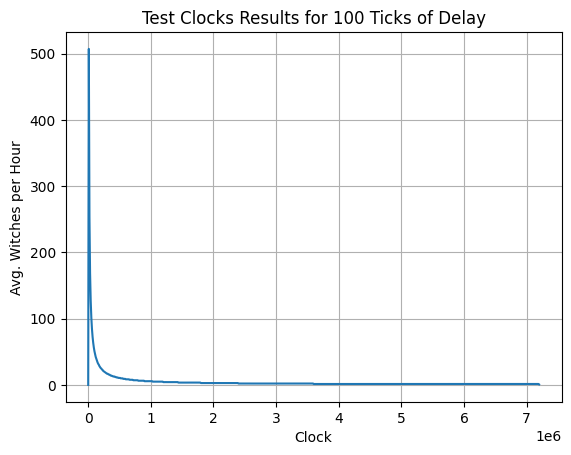

Max: 507.04 for 10000 tick clock


In [112]:
clocks_full = range(0, testPeriodTicks + 1, testPeriodTicks//720)
test_results(clocks_full,100)

Descartamos valores inútiles, tomemos solo del 300 al 2000, con intervalos de 100, para algunos posibles delays

In [116]:
clocks = range(300, 2000 + 1, 100)

In [ ]:
result_200 = test_results(clocks,200)

In [ ]:
result_100 = test_results(clocks,100)

In [ ]:
result_400 = test_results(clocks,4)

Ahora vamos a comparar nuestro modelo con datos reales

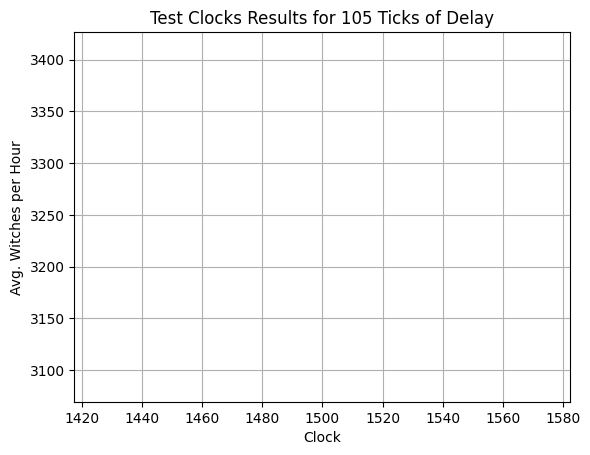

Max: 3248.08 for 1500 tick clock


In [14]:
result_1500 = test_results([1400,1500,1600],105)